# Splitting trajectories with moving pandas

For some cases, GPS tracks may leave the observation area for longer time before returning and continuing their recorded track. Therefore we might want to split trajectories at observation gaps that exceed a certain minimum duration.

In [9]:
def create_plot(data):
    # Ambil baris pertama dari DataFrame
    first_row = data.iloc[0]

    # Ambil nilai latitude dan longitude dari baris pertama
    latitude = first_row['latitude']
    longitude = first_row['longitude']
    
    m = folium.Map(location=[latitude, longitude], zoom_start=25)
    
    # Add CircleMarkers for each point
    for index, row in data.iterrows():
        folium.CircleMarker(
            location=[row["latitude"], row["longitude"]],
            radius=5,  # Marker size
            color="blue",  # Marker color
            fill=True,
            fill_color="blue",  # Fill color of the marker
            fill_opacity=0.7,  # Opacity of the marker fill
            popup=f"User ID: {row['maid']}<br>Latitude: {row['latitude']}<br>Longitude: {row['longitude']}",
        ).add_to(m)
    
    return m

In [195]:
import folium
from shapely.geometry import Point, LineString

def create_plot_line(data):
    # Buat peta dengan lokasi awal berdasarkan rata-rata koordinat dari data linestring
    linestring_avg_lat = data["geometry"].apply(lambda x: x.centroid.y).mean()
    linestring_avg_lon = data["geometry"].apply(lambda x: x.centroid.x).mean()
    m = folium.Map(location=[linestring_avg_lat, linestring_avg_lon], zoom_start=15)

    # Tambahkan polyline ke peta menggunakan titik-titik dari linestring
    for linestring in data["geometry"]:
        folium.PolyLine(locations=list(linestring.coords), color='blue', weight=5, opacity=0.7).add_to(m)

    # Tambahkan CircleMarkers untuk setiap titik
    for index, row in data.iterrows():
        for point in row["geometry"].coords:
            folium.CircleMarker(
                location=[point[1], point[0]],  # Urutan koordinat diubah karena folium menggunakan (lat, lon)
                radius=5,  # Ukuran marker
                color="blue",  # Warna marker
                fill=True,
                fill_color="blue",  # Warna pengisian marker
                fill_opacity=0.7,  # Opasitas pengisian marker
                popup=f"User ID: {row['maid']}<br>Latitude: {point[1]}<br>Longitude: {point[0]}",
            ).add_to(m)

    return m

In [254]:
def bar_chart_traj(df):
    df = df.copy()

    # Ambil tanggal dari kolom 'start_t' dan tambahkan sebagai kolom baru 'tanggal'
    df['tanggal'] = df['start_t'].dt.date
    
    # Menghitung jumlah data berdasarkan tanggal
    jumlah_data_per_tanggal = df.groupby('tanggal').size()

    # Plot bar chart
    plt.figure(figsize=(10, 6))
    jumlah_data_per_tanggal.plot(kind='bar', color='skyblue')
    plt.title(f'Jumlah Data per Tanggal: {jumlah_data_per_tanggal.sum()}')
    plt.xlabel('Tanggal')
    plt.ylabel('Jumlah Data Trajectory')
    plt.xticks(rotation=75)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [255]:
def bar_chart_maid(data):
    df = data.copy()
    
    # Ambil tanggal dari kolom 'start_t' dan tambahkan sebagai kolom baru 'tanggal'
    df['tanggal'] = df['start_t'].dt.date
    
    # Menghitung jumlah maid berdasarkan tanggal
    jumlah_maid_unik_per_hari = df.groupby('tanggal')['maid'].nunique()

    # Plotting
    plt.figure(figsize=(10, 6))
    jumlah_maid_unik_per_hari.plot(kind='bar', color='skyblue')
    plt.title(f'Total Jumlah Maid Unik per Hari: {jumlah_maid_unik_per_hari.sum()}')
    plt.xlabel('Tanggal')
    plt.ylabel('Jumlah Maid Unik')
    plt.xticks(rotation=75)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [2]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import shapely as shp
import hvplot.pandas 
import matplotlib.pyplot as plt
import geoviews
import folium
import mapclassify

from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
from holoviews import opts

import warnings
warnings.filterwarnings('ignore')

plot_defaults = {'linewidth':5, 'capstyle':'round', 'figsize':(9,3), 'legend':True}
opts.defaults(opts.Overlay(active_tools=['wheel_zoom'], frame_width=500, frame_height=400))

mpd.show_versions()


MovingPandas 0.17.2

SYSTEM INFO
-----------
python     : 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
executable : /raid/arkham/miniconda3/envs/arkham/bin/python3
machine    : Linux-4.15.0-142-generic-x86_64-with-glibc2.27

GEOS, GDAL, PROJ INFO
---------------------
GEOS       : None
GEOS lib   : None
GDAL       : 3.6.2
GDAL data dir: /raid/arkham/miniconda3/envs/arkham/lib/python3.10/site-packages/fiona/gdal_data
PROJ       : 9.3.1
PROJ data dir: /raid/arkham/miniconda3/envs/arkham/lib/python3.10/site-packages/pyproj/proj_dir/share/proj

PYTHON DEPENDENCIES
-------------------
geopandas  : 0.14.3
pandas     : 2.1.4
fiona      : 1.9.5
numpy      : 1.23.5
shapely    : 2.0.1
rtree      : 1.2.0
pyproj     : 3.6.1
matplotlib : 3.5.3
mapclassify: 2.6.1
geopy      : 2.4.0
holoviews  : 1.18.3
hvplot     : 0.9.2
geoviews   : 1.11.1
stonesoup  : None


In [4]:
df = pd.read_csv('../../../DataGPS_Malioboro/filter2_maljan_des.csv')
df_grouped = df.groupby(['maid', 'tanggal'])
tdf = mpd.TrajectoryCollection(df, traj_id_col='maid', t='datetime_wib', y='latitude', x='longitude')
tdf

TrajectoryCollection with 628 trajectories

In [5]:
len(df.groupby(['maid']))

671

## ObservationGapSplitter
Split the trajectory where then are no observations for at least 1 minutes:

In [6]:
index = 0
df_1min = pd.DataFrame()

while index < len(tdf):
    my_traj = tdf.trajectories[index]
    split = mpd.ObservationGapSplitter(my_traj).split(gap=timedelta(minutes=1))
    if len(split) > 1:
        split_df = split.to_traj_gdf()
        df_1min = df_1min._append(split_df, ignore_index=True)
    index += 1

In [178]:
from shapely.geometry import LineString

def create_line(data):
    data = data.to_crs('EPSG:4326')
    data = data['geometry']
    # Buat peta dengan lokasi awal berdasarkan rata-rata koordinat dari data linestring
    avg_lat = data.apply(lambda x: x.centroid.y).mean()
    avg_lon = data.apply(lambda x: x.centroid.x).mean()
    m = folium.Map(location=[avg_lat, avg_lon], zoom_start=15)

    # Tambahkan polyline untuk setiap linestring
    for linestring in data:
        coordinates = [(lat, lon) for lon, lat in linestring.coords]
        folium.PolyLine(locations=coordinates, color='purple', weight=8, opacity=0.7).add_to(m)

    # Tambahkan GeoJson dari data GeoPandas
    folium.GeoJson(data.to_json(), name='Garis Jalan').add_to(m)

    return m

In [171]:
df_1min_length = df_1min[df_1min['length'] > 0].reset_index(drop=True)

In [172]:
type(df_1min_length)

geopandas.geodataframe.GeoDataFrame

In [173]:
df_1min_length = df_1min_length.to_crs('EPSG:3857')
df_1min_length['geometry_len'] = df_1min_length['geometry'].length

In [174]:
df_1min_length_sorted = df_1min_length.sort_values(by='geometry_len', ascending=False).reset_index(drop=True)

In [248]:
df_1min_length_sorted['maid'] = df_1min_length_sorted['maid'].apply(lambda x: x.split('_')[0])
df_1min_length_sorted['maid'].nunique()

236

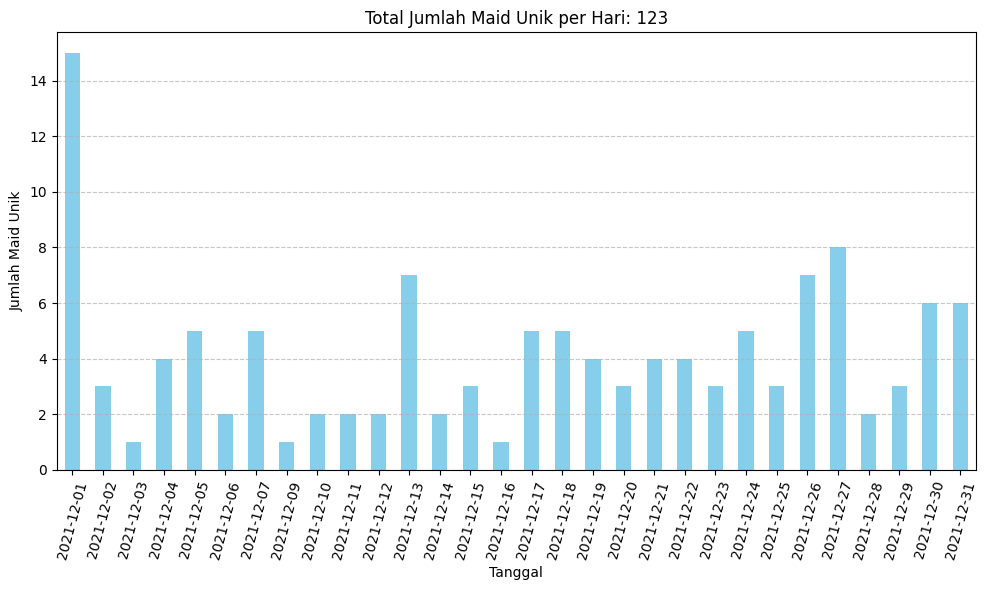

In [256]:
a = df_1min_length_sorted[df_1min_length_sorted['geometry_len']>5]
bar_chart_maid(a)

In [258]:
a

maid             start_t  \
0    a36ea4b5-8ee8-4f16-9d80-307e39a7aeba 2021-12-27 04:59:32   
1    a36ea4b5-8ee8-4f16-9d80-307e39a7aeba 2021-12-24 09:27:29   
2    d9c831f5-e789-497e-9f85-38d6aed039ff 2021-12-07 06:27:30   
3    d9c831f5-e789-497e-9f85-38d6aed039ff 2021-12-13 03:46:13   
4    0666e5d2-6152-4a1d-bf0c-a77f484cdfc7 2021-12-26 11:32:13   
..                                    ...                 ...   
320  1ddfe946-e7eb-4354-9547-1add42b4b70f 2021-12-02 00:11:31   
321  9a63fd0e-d363-478a-8136-99b1eb82693f 2021-12-07 12:59:00   
322  b46055f9-8b6b-437c-9202-635f04213704 2021-12-17 19:55:35   
323  a35a227e-16b4-44b7-967b-d1a230a2ef99 2021-12-01 19:02:18   
324  f501c8a1-e251-4b8c-87fc-9a1a26d2e19d 2021-12-23 10:57:10   

                  end_t                                           geometry  \
0   2021-12-27 05:02:33  LINESTRING (12285908.740 -869884.740, 12285861...   
1   2021-12-24 09:30:29  LINESTRING (12285883.581 -870032.601, 12285851...   
2   2021-12-07 06:29:45  LINESTRING (12285850.102 -870297.764, 12285850...   
3   2021-12-13 03:48:24  LINESTRING (12285847.959 -870315.741, 12285849...   
4   2021-12-26 11:38:24  LINESTRING (12285923.100 -869884.100, 12285923...   
..                  ...                                                ...   
320 2021-12-02 00:11:42  LINESTRING (12285859.444 -870238.215, 12285859...   
321 2021-12-07 12:59:55  LINESTRING (12285842.458 -870283.158, 12285842...   
322 2021-12-17 19:55:46  LINESTRING (12285891.718 -869880.920, 12285890...   
323 2021-12-01 19:02:29  LINESTRING (12285812.733 -870591.018, 12285815...   
324 2021-12-23 10:57:26  LINESTRING (12285803.391 -870880.903, 12285804...   

          length   direction  geometry_len  
0    1153.376028  187.128641   1171.642470  
1     854.559693  186.935763    868.098101  
2     806.171642  187.053924    818.928957  
3     796.282385  187.325723    808.880490  
4     782.687508  188.653339    795.001470  
..           ...         ...           ...  
320     5.155498   22.779502      5.231653  
321     5.088405  356.677566      5.169491  
322     5.097768  270.000000      5.161294  
323     5.019661   59.233516      5.082185  
324     4.967561    0.000000      5.040267  

[325 rows x 7 columns]

In [179]:
create_line(df_1min_length[df_1min_length['start_t'] <'2021-12-03'])

In [244]:
create_line(df_1min_length_sorted[:50])

In [192]:
create_line(df_1min_length_sorted[df_1min_length_sorted['start_t'] > '2021-12-22'])

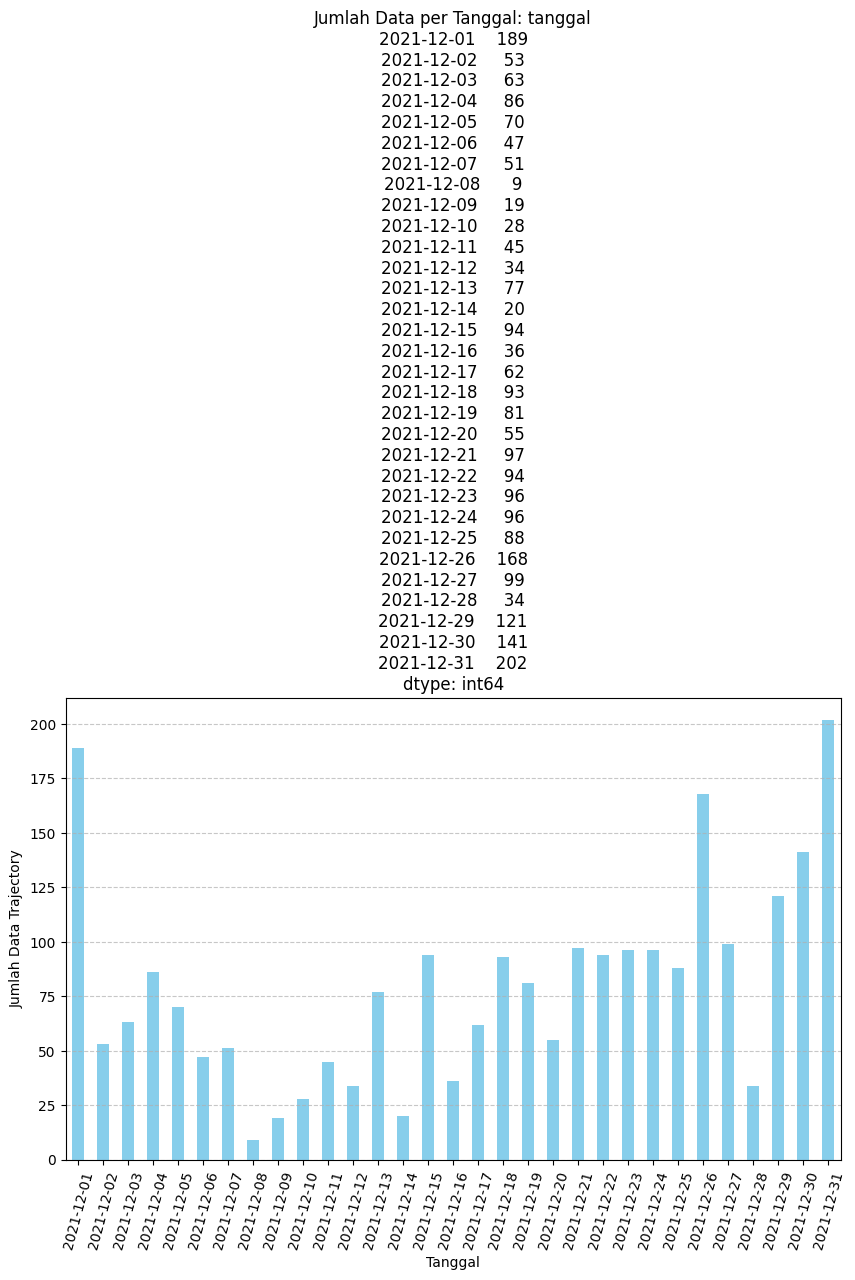

In [249]:
bar_chart_traj(df_1min_length_sorted)

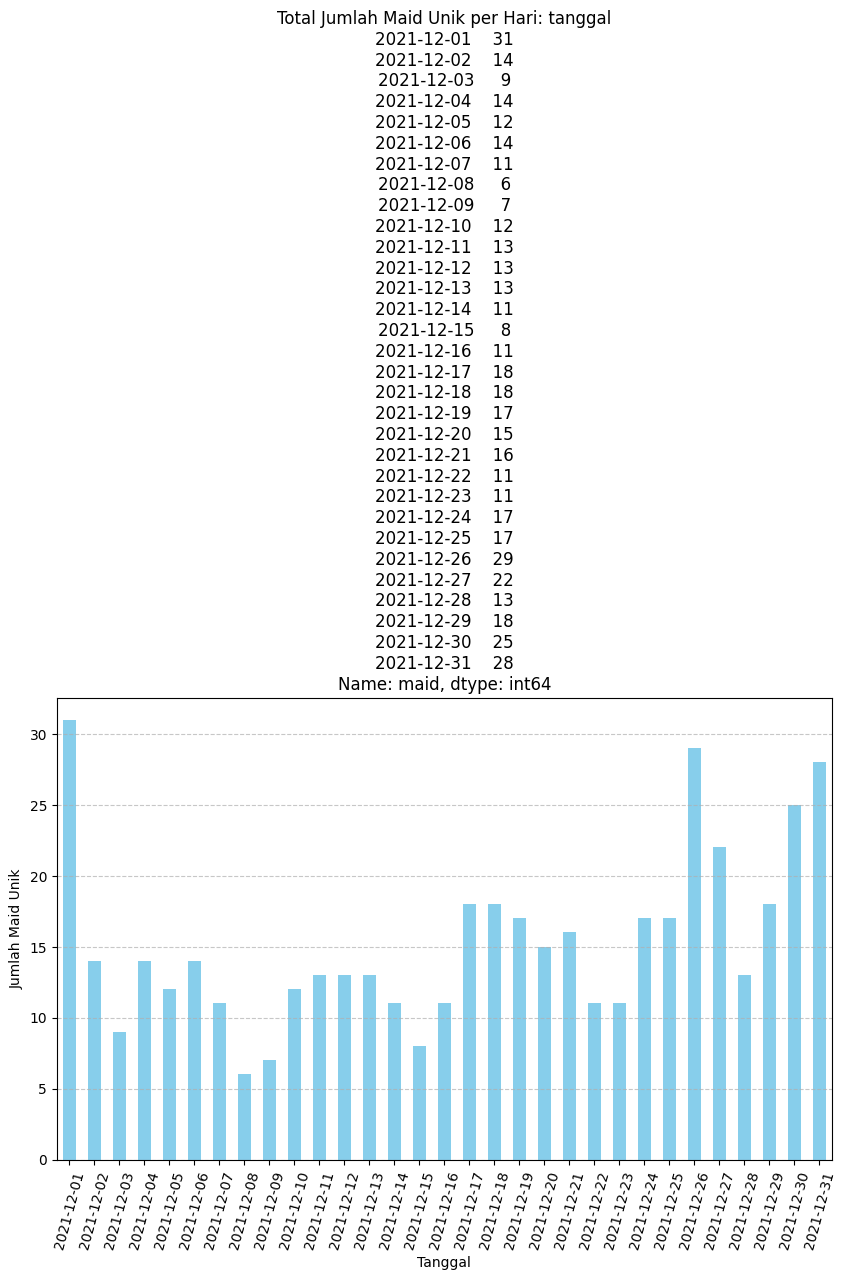

In [250]:
bar_chart_maid(df_1min_length_sorted)

In [238]:
len(df_1min_length_sorted)

2448